In [1]:
import matplotlib.pyplot as plt
import re
from scipy import stats
import numpy as np
import math
import matplotlib as mpl

In [2]:
systems = ['WT','NPG','ASV','SVD']
replicas = [1,2,3,4,5]

path1 = 'Pocket_Volume_Calculation'
path2 = 'C-Helix_Transition_Data'

In [3]:
data = []
index = 0 
all_systems = []
for sys in systems:
    for rep in replicas:
        sub = []
        all_systems.append(f"{sys} - {rep}")
        with open(f'{path1}/my_pocket_{sys}-{rep}/mdpout_descriptors.txt','r') as f1, open(f'{path2}/{sys}_{rep}_rmsd_and_angle_ts.dat','r') as f2:
            f1.readline()
            for l1, l2 in zip(f1, f2):
                l2 = re.split('\s+',l2)
                sub.append([float(re.split('\s+',l1)[1]),float(l2[0]), float(l2[1])])
        data.append(sub)

# Plot Correlations

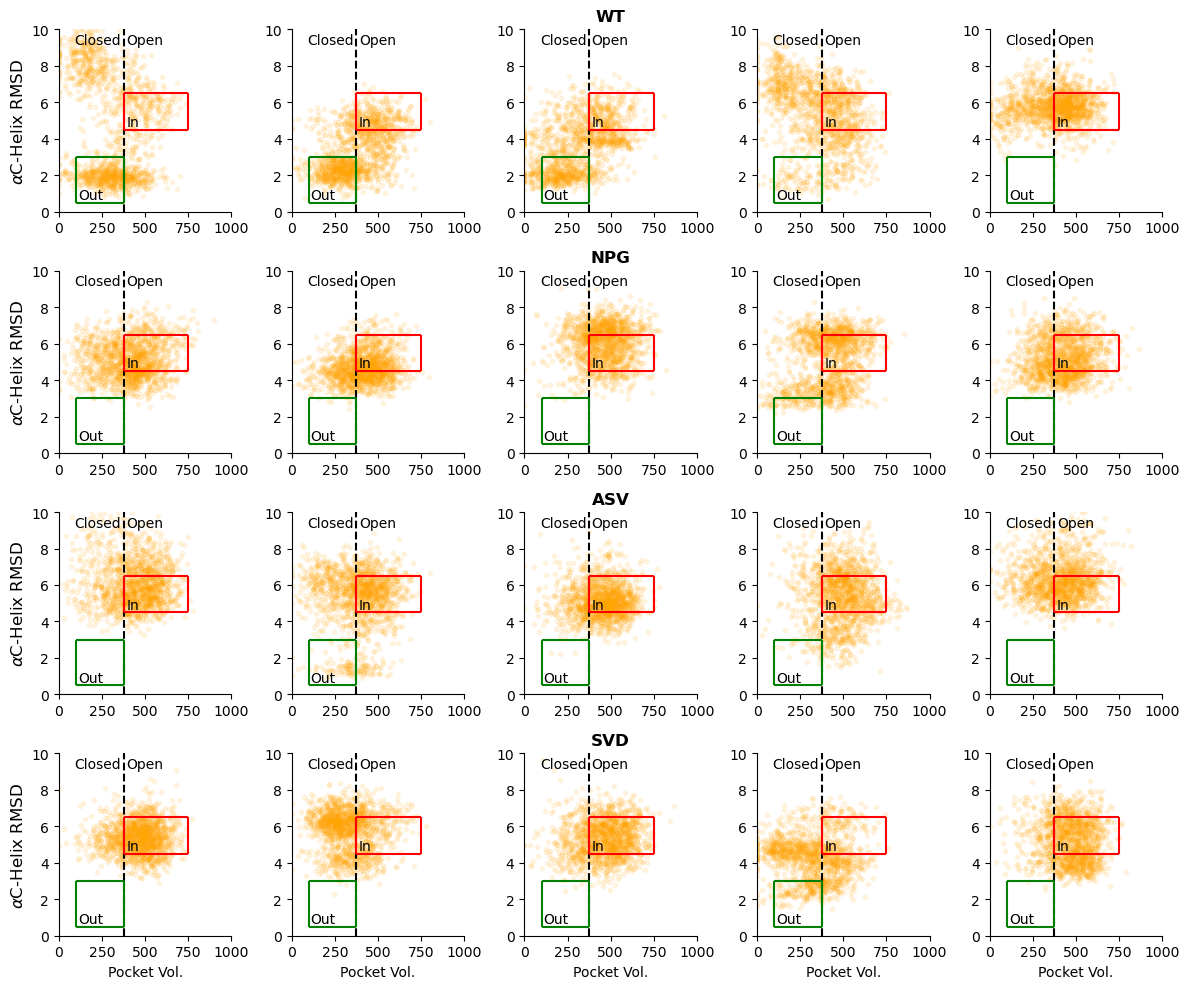

In [4]:
# Fold
cols = 5
rows = len(systems)
fig, ax = plt.subplots(rows, cols, figsize=(12, 10))
ax = ax.flatten()

title_spots = [2,7,12,17]
flag = 0
for n in range(cols*rows):
    if n < len(data):
        ax[n].plot([x[0] for x in data[n]], [y[1] for y in data[n]], '.', color='Orange',alpha=0.1)
        
        ax[n].vlines(375, 0, 10, color="Black", linestyles="dashed")
        
        ax[n].hlines(4.5, 375, 750, color="red")
        ax[n].hlines(6.5, 375, 750, color="red")
        ax[n].vlines(375, 4.5, 6.5, color="red")
        ax[n].vlines(750, 4.5, 6.5, color="red")
        
        ax[n].hlines(0.5, 100, 375, color="Green")
        ax[n].hlines(3.0, 100, 375, color="Green")
        ax[n].vlines(100, 0.5, 3.0, color="Green")
        ax[n].vlines(375, 0.5, 3.0, color="Green")
        
        ax[n].text(110, 0.7, 'Out',fontsize=10)        
        ax[n].text(390, 4.7, 'In',fontsize=10)
        ax[n].text(90, 9.2, 'Closed',fontsize=10)
        ax[n].text(390, 9.2,'Open',fontsize=10)
        
        if n in title_spots:
            ax[n].set_title(f'{systems[flag]}',fontsize=12, weight='bold')
            flag += 1
        
        if n%5 == 0:
            ax[n].set_ylabel(r'$\alpha$C-Helix RMSD',fontsize=12)
        if n > (cols*rows-6):
            ax[n].set_xlabel('Pocket Vol.',fontsize=10)
        ax[n].set_ylim(0, 10)
        ax[n].set_xlim(0, 1000)
        ax[n].spines['right'].set_visible(False)
        ax[n].spines['top'].set_visible(False)
    else: 
        ax[n].remove()
    
plt.tight_layout()
#plt.savefig('TS_K745-E762_WT-to.png',dpi=360)

# Plot Heat Map - Make Extended Data Figure 1B

In [5]:
def get_FES(x, y):
    kde = stats.gaussian_kde([x, y]) # Calculate the Density with gassian_kde
    gridsize=250
    buff = 10
    #print('X, Min: {}, Max: {}'.format(min(x), max(x)))
    #print('Y, Min: {}, Max: {}'.format(min(y), max(y)))
    xx, yy = np.mgrid[min(x)-buff:max(x)+buff:(max(x)-min(x)+(2*buff))/gridsize, 
                      min(y)-buff:max(y)+buff:(max(y)-min(y)+(2*buff))/gridsize]
    density = ((kde(np.c_[xx.flat, yy.flat].T))).reshape(xx.shape)
    fes = np.empty((len(density), len(density[0])))
    
    # Clean the Density Map/Grid and Calculate the dG
    for i in range(0,len(density)):
        for j in range(0, len(density[i])):
            if density[i][j] < 0.000001: # Cutoff for low density values
                density[i][j]='NaN'
                fes[i][j]='NaN'
            else:
                fes[i][j] = -(0.593)*math.log(density[i][j]) # RT = 0.593 (kcal/mol)
    
    # Shift dG of the FES down so min is zero.
    fes_final = np.empty((len(density), len(density[0])))
    all_dG = [x for y in fes for x in y if np.isnan(x) == False]
    #print(min(all_dG), max(all_dG))
    for i in range(0, len(fes)):
        for j in range(0, len(fes[i])):
            if np.isnan(fes[i][j]):
                fes_final[i][j] = fes[i][j]
            else:
                fes_final[i][j] = fes[i][j] - min(all_dG)
    return xx, yy, density, fes_final, min(all_dG)-min(all_dG), max(all_dG)-min(all_dG) 

Take a look at the dens min and max to play with the color intensity.

In [6]:
test_n = 3
XX, YY, dens, bad, bad_min, bad_max = get_FES([x[0] for x in data[test_n]], [y[1] for y in data[test_n]])

Plot that Data

/var/folders/qg/ryp6jg892tvdmbv3cmyvksgm0000gp/T/ipykernel_21596/2557119019.py:15: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  cset.collections[0].remove()
/var/folders/qg/ryp6jg892tvdmbv3cmyvksgm0000gp/T/ipykernel_21596/2557119019.py:16: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  cset.collections[1].remove()


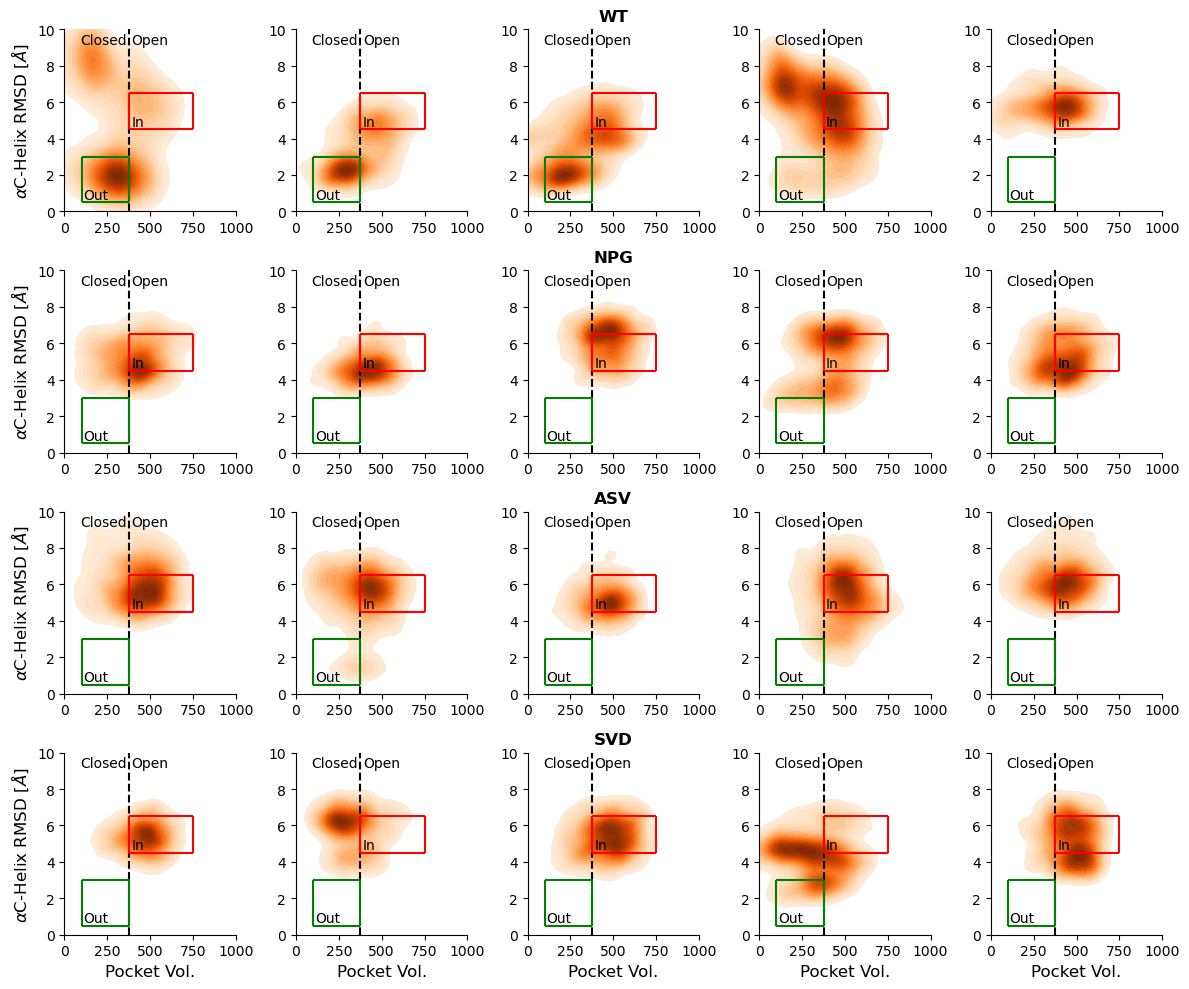

In [12]:
# Fold
cols = 5
rows = len(systems)
fig, ax = plt.subplots(rows, cols, figsize=(12, 10))
ax = ax.flatten()
cmap = mpl.cm.Oranges

title_spots = [2,7,12,17]
flag = 0
for n in range(cols*rows):
    if n < len(data):
        #ax[n].plot([x[0] for x in data[n]], [y[1] for y in data[n]], '.', color='#FF6200',alpha=0.1)
        XX, YY, dens, bad, bad_min, bad_max = get_FES([x[0] for x in data[n]], [y[1] for y in data[n]]) 
        cset = ax[n].contourf(XX, YY, dens, 30, cmap=cmap)
        cset.collections[0].remove()
        cset.collections[1].remove()
        
        ax[n].vlines(375, 0, 10, color="Black", linestyles="dashed")
        
        ax[n].hlines(4.5, 375, 750, color="red")
        ax[n].hlines(6.5, 375, 750, color="red")
        ax[n].vlines(375, 4.5, 6.5, color="red")
        ax[n].vlines(750, 4.5, 6.5, color="red")
        
        ax[n].hlines(0.5, 100, 375, color="Green")
        ax[n].hlines(3.0, 100, 375, color="Green")
        ax[n].vlines(100, 0.5, 3.0, color="Green")
        ax[n].vlines(375, 0.5, 3.0, color="Green")
        
        ax[n].text(110, 0.7, 'Out',fontsize=10)        
        ax[n].text(390, 4.7, 'In',fontsize=10)
        ax[n].text(90, 9.2, 'Closed',fontsize=10)
        ax[n].text(390, 9.2,'Open',fontsize=10)
        
        
        if n in title_spots:
            ax[n].set_title(f'{systems[flag]}',fontsize=12, weight='bold')
            flag += 1
        
        if n%5 == 0:
            ax[n].set_ylabel(r'$\alpha$C-Helix RMSD [$\AA$]',fontsize=12)
        if n > (cols*rows-6):
            ax[n].set_xlabel('Pocket Vol.',fontsize=12)
        ax[n].set_ylim(0, 10)
        ax[n].set_xlim(0, 1000)
        ax[n].spines['right'].set_visible(False)
        ax[n].spines['top'].set_visible(False)
    else: 
        ax[n].remove()
    
plt.tight_layout()
plt.savefig('plots/Extended_Data_Fig_1B.pdf',dpi=600)

# Pocket Volume Statistics

In [8]:
final_data = []
final_data_err = []
count = 0
for sys in systems:
    print(sys)
    sys_out = []
    sys_mid = []
    sys_ins = []
    for rep in replicas:
        for dat in data[count]:
            if dat[1] < 3:
                sys_out.append(dat[0])
            elif dat[1] < 4.5 and dat[1] >= 3:
                sys_mid.append(dat[0])
            #elif dat[1] >= 6.5: # Updated to place extended state in intermediate state.
            #    sys_mid.append(dat[0])
            elif dat[1] >= 4.5 and dat[1] < 6.5: # Updated to exclude extended state.
                sys_ins.append(dat[0])
        count += 1
    print('----- Mean of Means ----------')
    print(f"{len(sys_out)/7500:0.2f},{len(sys_mid)/7500:0.2f},{len(sys_ins)/7500:0.2f}")
    print(f"{np.mean(sys_out):0.2f} {np.mean(sys_mid):0.2f} {np.mean(sys_ins):0.2f}")
    final_data.append([sys, np.mean(sys_out), np.mean(sys_mid), np.mean(sys_ins)])
    final_data_err.append([sys, np.std(sys_out), np.std(sys_mid), np.std(sys_ins)])
    print('------------------------------')  

WT
----- Mean of Means ----------
0.29,0.17,0.36
291.30 392.37 393.00
------------------------------
NPG
----- Mean of Means ----------
0.02,0.28,0.52
325.74 395.62 428.24
------------------------------
ASV
----- Mean of Means ----------
0.04,0.13,0.59
388.99 440.31 436.75
------------------------------
SVD
----- Mean of Means ----------
0.04,0.24,0.58
326.85 409.95 410.40
------------------------------


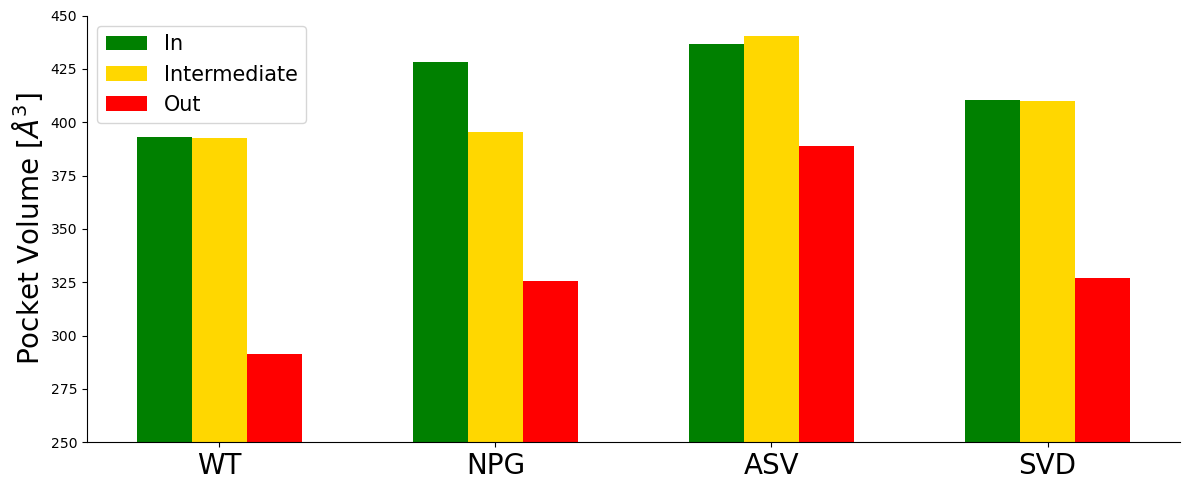

In [9]:
# Fold
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ins_state = [x[3] for x in final_data]
mid_state = [x[2] for x in final_data]
out_state = [x[1] for x in final_data]

X_axis = np.arange(len(systems))

ax.bar(X_axis - 0.2, ins_state, 0.2, label = 'In', color = 'Green')
ax.bar(X_axis + 0.0, mid_state, 0.2, label = 'Intermediate', color = 'Gold')
ax.bar(X_axis + 0.2, out_state, 0.2, label = 'Out', color = 'Red')

plt.xticks(X_axis, systems,fontsize=20)

ax.set_ylim(250,450)
ax.set_ylabel('Pocket Volume [$\AA^3$]',fontsize='20')
#plt.yticks([300, 350, 400, 450],fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(fontsize=15)
plt.tight_layout()

# Final Plot for Paper - Figure 1E

Keep in mind that the sampling size of out-state pocket volumes are so small for NPG, ASV, and SVD, that only the WT state can be accurately estimated! 

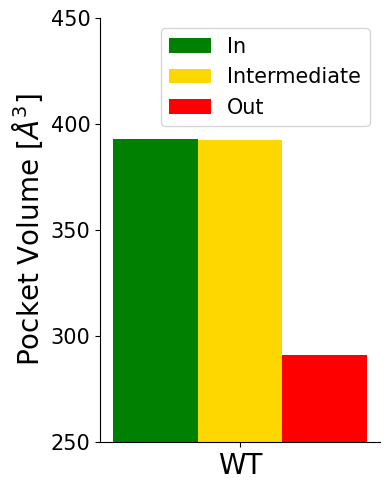

In [11]:
# Fold
fig, ax = plt.subplots(1, 1, figsize=(4, 5))

X = ["WT"]

ins_state = [final_data[0][3]]
mid_state = [final_data[0][2]]
out_state = [final_data[0][1]]

X_axis = np.arange(len(X))

ax.bar(X_axis - 0.2, ins_state, 0.2, label = 'In', color = 'Green')
ax.bar(X_axis + 0.0, mid_state, 0.2, label = 'Intermediate', color = 'Gold')
ax.bar(X_axis + 0.2, out_state, 0.2, label = 'Out', color = 'Red')

plt.xticks(X_axis, X,fontsize=20)

ax.set_ylim(250,450)
ax.set_ylabel('Pocket Volume [$\AA^3$]',fontsize='20')
plt.yticks([250, 300, 350, 400, 450],fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('plots/Fig_1E.png',dpi=360, transparent=True)